# Analysis of the results

This notebook investigates the results of all the model runs in the directory `results/runs`.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

RESULTS_DIR = os.path.join("results", "runs")
ARVIZ_STYLE = "arviz-redish"

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
run_dirs = [
    os.path.join(RESULTS_DIR, d)
    for d in os.listdir(RESULTS_DIR)
    if os.path.isdir(os.path.join(".", RESULTS_DIR, d))
]
priors = {}
posteriors = {}

for run_dir in run_dirs:
    prior_file = os.path.join(run_dir, "prior.json")
    posterior_file = os.path.join(run_dir, "posterior.json")
    if os.path.exists(prior_file):
        priors[os.path.basename(run_dir)] = az.from_json(prior_file)
    if os.path.exists(posterior_file):
        posterior = az.from_json(posterior_file)
        posteriors[os.path.basename(run_dir)] = posterior
        
priors["interaction"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Some of the runs may also have results of exact cross-validation, also saved in json files. 

While its convenient to store the cross-validation files separately, for analysis it's nice to have them in the same place as their posteriors, so the next cell loads the cross-validation jsons and adds them to the matching posterior `InferenceData`s.

In [3]:
for posterior_name, posterior in posteriors.items():
    llik_cv_file = os.path.join(RESULTS_DIR, posterior_name, "llik_cv.json")
    if os.path.exists(llik_cv_file):
        with open(llik_cv_file, "r") as f:
            llik_cv_dict = json.load(f)
        llik_cv = xarray.Dataset.from_dict(llik_cv_dict)
        posterior.add_groups({"log_likelihood_cv": llik_cv})
posteriors["interaction"]

/Users/tedgro/Code/cookiecutter-cmdstanpy-analysis/my_cool_project/.venv/lib/python3.10/site-packages/arviz/data/inference_data.py:1361: UserWarning: The group log_likelihood_cv is not defined in the InferenceData scheme
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> log_likelihood_cv

In [4]:
xarray.Dataset.from_dict(llik_cv_dict)

<xarray.Dataset>
Dimensions:      (chain: 1, draw: 2000, observation: 10, ix_test: 10)
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * observation  (observation) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: ix_test
Data variables:
    llik         (ix_test, chain, draw, observation) float64 -0.5371 ... -0.3858
Attributes:
    created_at:                 2022-07-29T08:54:09.264547
    arviz_version:              0.12.1
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

In [5]:
t = xarray.Dataset.from_dict(llik_cv_dict)
t

<xarray.Dataset>
Dimensions:      (chain: 1, draw: 2000, observation: 10, ix_test: 10)
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * observation  (observation) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: ix_test
Data variables:
    llik         (ix_test, chain, draw, observation) float64 -0.5371 ... -0.3858
Attributes:
    created_at:                 2022-07-29T08:54:09.264547
    arviz_version:              0.12.1
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

## Comparing predictions

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected log predictive density for each `InferenceData` object in the `posteriors` dictionary.

It then calculates the same quantity using exact k-fold cross-validation.

In [6]:
posterior_loo_comparison = az.compare(posteriors)

posterior_kfold_comparison = pd.Series(
    {
        posterior_name:
            float(
                posterior.get("log_likelihood_cv")["llik"]
                .mean(dim=["chain", "draw"])
                .sum()
            )
        for posterior_name, posterior in posteriors.items() 
        if "log_likelihood_cv" in posterior.groups()
    }, name="kfold"
)

posterior_comparison = posterior_loo_comparison.join(posterior_kfold_comparison)

posterior_comparison

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,kfold
interaction_fake_data,0,-26.704815,4.100822,0.000000,1.000000e+00,6.143677,0.000000,False,log,-29.948195
no_interaction,1,-85.382917,3.668600,58.678102,0.000000e+00,6.795554,9.413008,False,log,-88.207814
interaction,2,-86.415132,4.246213,59.710318,9.360290e-12,6.729888,9.395355,False,log,-88.222130


## Graphs

The last cell uses arviz to plot each posterior predictive distribution and saves the result to the `plots` directory.

/Users/tedgro/Code/cookiecutter-cmdstanpy-analysis/my_cool_project/.venv/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/Users/tedgro/Code/cookiecutter-cmdstanpy-analysis/my_cool_project/.venv/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


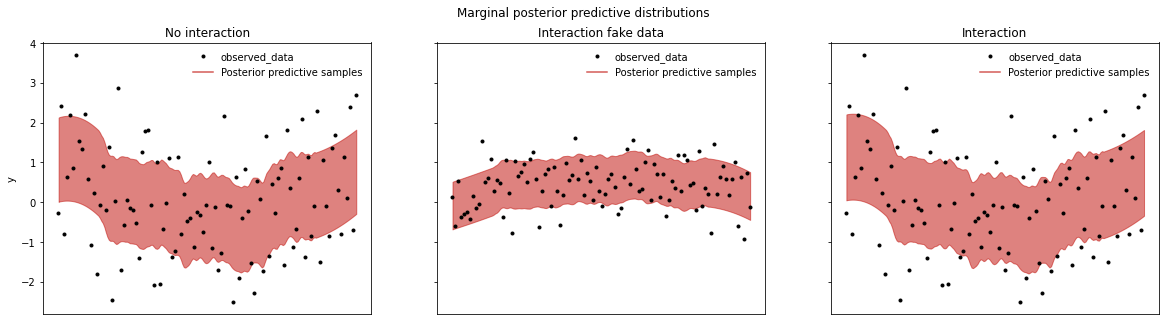

In [7]:
az.style.use(ARVIZ_STYLE)

x = xarray.DataArray(np.linspace(0, 1, 100))
f, axes = plt.subplots(1, 3, figsize=[20, 5], sharey=True)
axes = axes.ravel()
for (posterior_name, posterior), ax in zip(posteriors.items(), axes):
        az.plot_lm(
            y="y",
            x=x,
            idata=posterior,
            y_hat="yrep",
            axes=ax,
            kind_pp="hdi",
            y_kwargs={"markersize": 6, "color":"black"},
            grid=False
        )
        ax.legend(frameon=False)
        ax.set(title=posterior_name.replace("_", " ").capitalize(), ylabel="")
        ax.set_xticks([], [])
axes[0].set_ylabel("y")

f.suptitle("Marginal posterior predictive distributions")
f.savefig(os.path.join("results", "plots", "posterior_predictive_comparison.png"))